# CDS Model vs Market Correlation Analysis

This notebook analyzes the correlation between model-implied CDS spreads and actual market CDS spreads.

**Key Metrics:**
1. **RMSE**: Root Mean Squared Error (accuracy of spread levels)
2. **Correlation of Levels**: How well model and market spreads move together
3. **Correlation of Changes**: How well models capture daily CDS spread dynamics (Byström 2006)

**Statistical Testing:**
- Pearson correlation coefficient (r)
- Significance testing (t-test)
- Confidence intervals
- Model comparison tests

In [1]:
# Setup
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils import config

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Setup complete")

✓ Setup complete


## 0. Leverage Analysis and Firm Grouping

Calculate leverage ratios for each firm and create three groups:
- **Low Leverage**: Bottom tercile
- **Mid Leverage**: Middle tercile  
- **High Leverage**: Top tercile

**Leverage Ratio Definition**: `Liabilities / (Liabilities + Market Cap)`

This represents the debt-to-assets ratio using market values.

In [2]:
# Load merged data with Merton results to get leverage information
df_merged = pd.read_csv(config.OUTPUT_DIR / 'merged_data_with_merton.csv')
df_merged['date'] = pd.to_datetime(df_merged['date'])

print(f"Loaded {len(df_merged)} rows of merged data")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")
print(f"Number of firms: {df_merged['gvkey'].nunique()}")

# Calculate leverage ratio for each firm-date
# Leverage = Liabilities / (Liabilities + Market Cap)
# This is the debt-to-assets ratio using market values
df_merged['leverage_ratio'] = df_merged['liabilities_total'] / (df_merged['liabilities_total'] + df_merged['mkt_cap'])

# Calculate average leverage for each firm over the entire period
firm_leverage = df_merged.groupby('gvkey').agg({
    'leverage_ratio': 'mean',
    'company': 'first',
    'liabilities_total': 'mean',
    'mkt_cap': 'mean'
}).reset_index()

firm_leverage.columns = ['gvkey', 'avg_leverage', 'company', 'avg_liabilities', 'avg_mkt_cap']

# Sort by leverage
firm_leverage = firm_leverage.sort_values('avg_leverage', ascending=False)

print(f"\nLeverage Summary:")
print(f"Min leverage: {firm_leverage['avg_leverage'].min():.2%}")
print(f"Max leverage: {firm_leverage['avg_leverage'].max():.2%}")
print(f"Mean leverage: {firm_leverage['avg_leverage'].mean():.2%}")
print(f"Median leverage: {firm_leverage['avg_leverage'].median():.2%}")

# Display all firms with leverage ratios
print(f"\n{'='*80}")
print(f"Leverage Ratios by Firm (sorted from highest to lowest):")
print(f"{'='*80}")
for idx, row in firm_leverage.iterrows():
    print(f"{row['company']:40s} | gvkey: {row['gvkey']:6d} | Leverage: {row['avg_leverage']:6.2%} | Debt: €{row['avg_liabilities']/1e9:6.1f}B | Equity: €{row['avg_mkt_cap']/1e9:6.1f}B")

firm_leverage.head(10)

Loaded 133008 rows of merged data
Date range: 2010-01-04 00:00:00 to 2024-12-31 00:00:00
Number of firms: 34

Leverage Summary:
Min leverage: 10.90%
Max leverage: 97.06%
Mean leverage: 55.26%
Median leverage: 50.28%

Leverage Ratios by Firm (sorted from highest to lowest):
BNP PARIBAS                              | gvkey:  15532 | Leverage: 97.06% | Debt: €2076.2B | Equity: €  62.0B
UNICREDIT SPA                            | gvkey:  15549 | Leverage: 96.41% | Debt: € 809.6B | Equity: €  29.8B
ING GROEP NV                             | gvkey:  15617 | Leverage: 95.79% | Debt: € 946.7B | Equity: €  40.0B
INTESA SANPAOLO SPA                      | gvkey:  16348 | Leverage: 95.19% | Debt: € 739.7B | Equity: €  37.4B
AXA SA                                   | gvkey:  63120 | Leverage: 93.43% | Debt: € 713.1B | Equity: €  49.7B
ALLIANZ SE                               | gvkey:  15724 | Leverage: 92.22% | Debt: € 814.8B | Equity: €  70.0B
MUNICH RE CO                             | gvkey:  156

,gvkey,avg_leverage,company,avg_liabilities,avg_mkt_cap
1,15532,0.970620,BNP PARIBAS,2.076241e+12,6.195829e+10
2,15549,0.964095,UNICREDIT SPA,8.095950e+11,2.980309e+10
3,15617,0.957899,ING GROEP NV,9.466680e+11,4.001000e+10
6,16348,0.951909,INTESA SANPAOLO SPA,7.397296e+11,3.739438e+10
14,63120,0.934321,AXA SA,7.130574e+11,4.969499e+10
5,15724,0.922230,ALLIANZ SE,8.148249e+11,7.000736e+10
4,15677,0.888110,MUNICH RE CO,2.449800e+11,3.142102e+10
15,100022,0.742461,BAYERISCHE MOTOREN WERKE AKT,1.339451e+11,4.607415e+10
26,201794,0.723472,ENEL SPA,1.251179e+11,4.913249e+10
28,220940,0.669716,ORANGE SA,6.575563e+10,3.265043e+10


In [3]:
# Create three groups based on leverage terciles
firm_leverage['leverage_tercile'] = pd.qcut(
    firm_leverage['avg_leverage'], 
    q=3, 
    labels=['Low Leverage', 'Mid Leverage', 'High Leverage']
)

# Get tercile boundaries
tercile_boundaries = pd.qcut(firm_leverage['avg_leverage'], q=3, retbins=True)[1]

print("\nLeverage Group Definitions:")
print(f"Low Leverage:  < {tercile_boundaries[1]:.2%}")
print(f"Mid Leverage:  {tercile_boundaries[1]:.2%} - {tercile_boundaries[2]:.2%}")
print(f"High Leverage: > {tercile_boundaries[2]:.2%}")

# Display firms by group
for group in ['High Leverage', 'Mid Leverage', 'Low Leverage']:
    group_firms = firm_leverage[firm_leverage['leverage_tercile'] == group]
    print(f"\n{'='*80}")
    print(f"{group.upper()} ({len(group_firms)} firms)")
    print(f"{'='*80}")
    for idx, row in group_firms.iterrows():
        print(f"{row['company']:40s} | gvkey: {row['gvkey']:6d} | Leverage: {row['avg_leverage']:6.2%}")

# Create mapping dictionary for easy lookup
leverage_group_map = firm_leverage.set_index('gvkey')['leverage_tercile'].to_dict()

print(f"\n✓ Created leverage groups: {firm_leverage['leverage_tercile'].value_counts().to_dict()}")


Leverage Group Definitions:
Low Leverage:  < 42.36%
Mid Leverage:  42.36% - 64.71%
High Leverage: > 64.71%

HIGH LEVERAGE (11 firms)
BNP PARIBAS                              | gvkey:  15532 | Leverage: 97.06%
UNICREDIT SPA                            | gvkey:  15549 | Leverage: 96.41%
ING GROEP NV                             | gvkey:  15617 | Leverage: 95.79%
INTESA SANPAOLO SPA                      | gvkey:  16348 | Leverage: 95.19%
AXA SA                                   | gvkey:  63120 | Leverage: 93.43%
ALLIANZ SE                               | gvkey:  15724 | Leverage: 92.22%
MUNICH RE CO                             | gvkey:  15677 | Leverage: 88.81%
BAYERISCHE MOTOREN WERKE AKT             | gvkey: 100022 | Leverage: 74.25%
ENEL SPA                                 | gvkey: 201794 | Leverage: 72.35%
ORANGE SA                                | gvkey: 220940 | Leverage: 66.97%
DEUTSCHE TELEKOM                         | gvkey: 221616 | Leverage: 64.79%

MID LEVERAGE (11 firms)
AIRBU

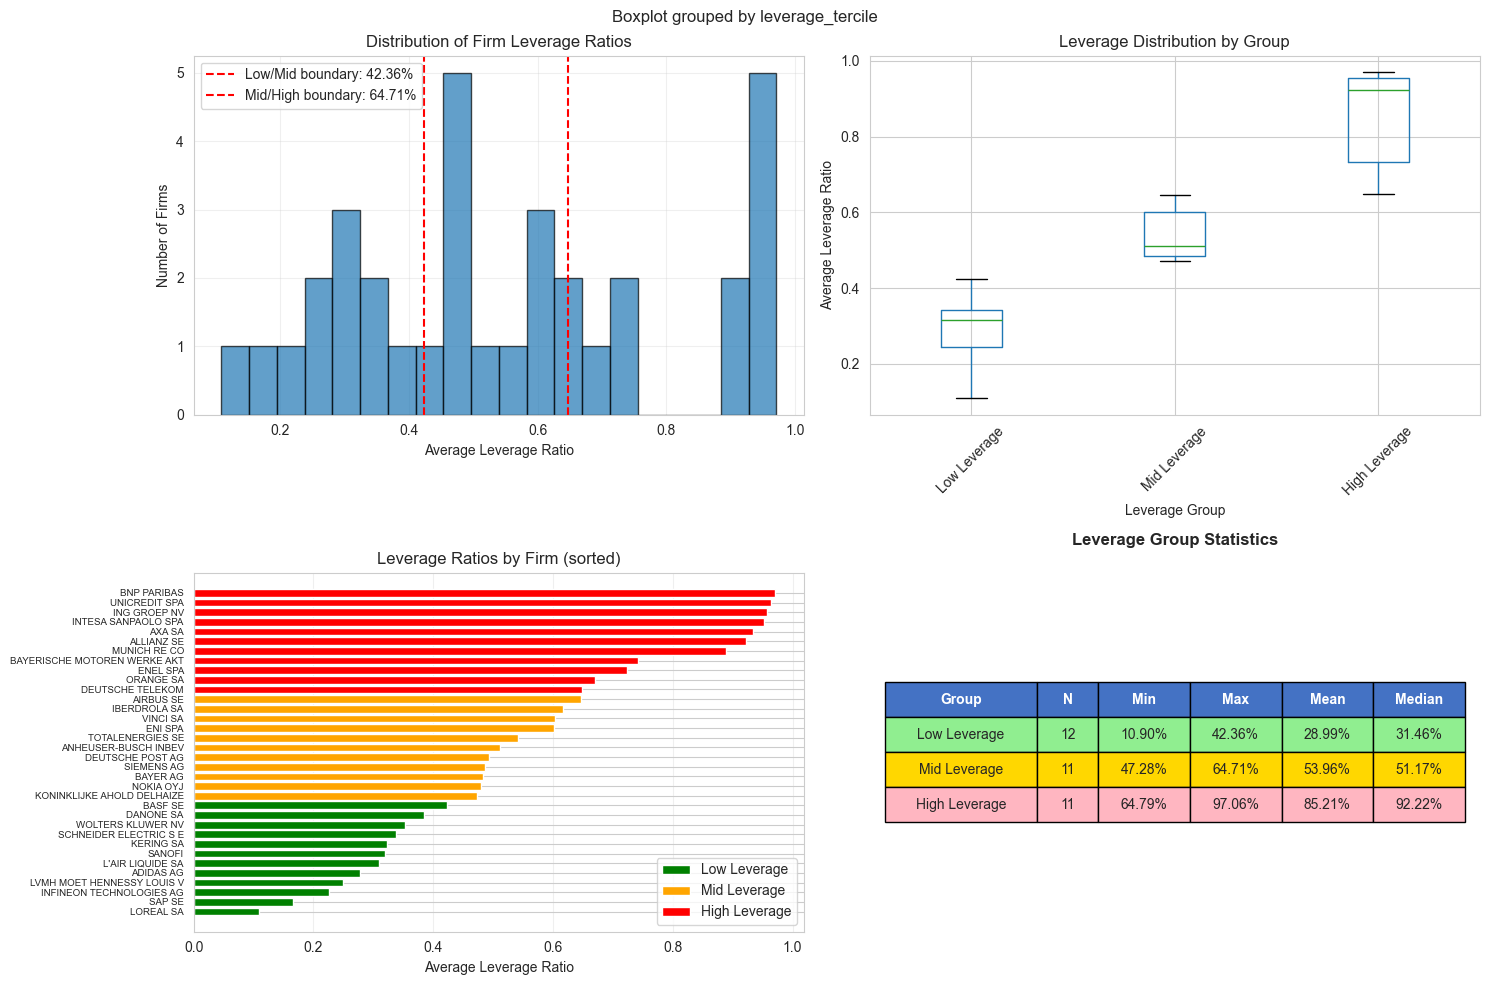

✓ Leverage visualization complete


In [4]:
# Visualize leverage distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of leverage ratios
ax1 = axes[0, 0]
ax1.hist(firm_leverage['avg_leverage'], bins=20, edgecolor='black', alpha=0.7)
ax1.axvline(tercile_boundaries[1], color='red', linestyle='--', label=f'Low/Mid boundary: {tercile_boundaries[1]:.2%}')
ax1.axvline(tercile_boundaries[2], color='red', linestyle='--', label=f'Mid/High boundary: {tercile_boundaries[2]:.2%}')
ax1.set_xlabel('Average Leverage Ratio')
ax1.set_ylabel('Number of Firms')
ax1.set_title('Distribution of Firm Leverage Ratios')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot by group
ax2 = axes[0, 1]
firm_leverage.boxplot(column='avg_leverage', by='leverage_tercile', ax=ax2)
ax2.set_xlabel('Leverage Group')
ax2.set_ylabel('Average Leverage Ratio')
ax2.set_title('Leverage Distribution by Group')
plt.sca(ax2)
plt.xticks(rotation=45)

# 3. Bar chart of firms in each group (sorted by leverage)
ax3 = axes[1, 0]
colors = {'High Leverage': 'red', 'Mid Leverage': 'orange', 'Low Leverage': 'green'}
firm_leverage_sorted = firm_leverage.sort_values('avg_leverage', ascending=True)
bars = ax3.barh(range(len(firm_leverage_sorted)), 
                firm_leverage_sorted['avg_leverage'],
                color=[colors[g] for g in firm_leverage_sorted['leverage_tercile']])
ax3.set_yticks(range(len(firm_leverage_sorted)))
ax3.set_yticklabels(firm_leverage_sorted['company'], fontsize=7)
ax3.set_xlabel('Average Leverage Ratio')
ax3.set_title('Leverage Ratios by Firm (sorted)')
ax3.grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[g], label=g) for g in ['Low Leverage', 'Mid Leverage', 'High Leverage']]
ax3.legend(handles=legend_elements, loc='lower right')

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')
summary_stats = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_data = firm_leverage[firm_leverage['leverage_tercile'] == group]['avg_leverage']
    summary_stats.append([
        group,
        len(group_data),
        f"{group_data.min():.2%}",
        f"{group_data.max():.2%}",
        f"{group_data.mean():.2%}",
        f"{group_data.median():.2%}"
    ])

table_data = [['Group', 'N', 'Min', 'Max', 'Mean', 'Median']] + summary_stats
table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.1, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(6):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by group
for i, group in enumerate(['Low Leverage', 'Mid Leverage', 'High Leverage'], 1):
    color = {'Low Leverage': '#90EE90', 'Mid Leverage': '#FFD700', 'High Leverage': '#FFB6C1'}[group]
    for j in range(6):
        table[(i, j)].set_facecolor(color)

ax4.set_title('Leverage Group Statistics', fontsize=12, weight='bold', pad=20)

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'leverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Leverage visualization complete")

## 1. Load Correlation Results

Load the pre-computed correlation results from the main pipeline.

In [5]:
# Load results
results_df = pd.read_csv(config.OUTPUT_DIR / 'cds_model_vs_market_correlations.csv')

print(f"Loaded {len(results_df)} firm-level correlation results")
print(f"\nColumns: {results_df.columns.tolist()}")
print(f"\nCompanies: {results_df['company'].nunique()}")
results_df.head()

Loaded 34 firm-level correlation results

Columns: ['company', 'gvkey', 'n_obs', 'Merton_MC_rmse', 'Merton_MC_corr_lvl', 'Merton_MC_corr_chg', 'GARCH_rmse', 'GARCH_corr_lvl', 'GARCH_corr_chg', 'RS_rmse', 'RS_corr_lvl', 'RS_corr_chg', 'MSGARCH_rmse', 'MSGARCH_corr_lvl', 'MSGARCH_corr_chg']

Companies: 34


,company,gvkey,n_obs,Merton_MC_rmse,Merton_MC_corr_lvl,Merton_MC_corr_chg,GARCH_rmse,GARCH_corr_lvl,GARCH_corr_chg,RS_rmse,RS_corr_lvl,RS_corr_chg,MSGARCH_rmse,MSGARCH_corr_lvl,MSGARCH_corr_chg
0,SANOFI,101204,3762,38.930790,0.025342,0.006161,38.753479,0.030543,0.002131,38.430825,0.008100,0.019033,39.365513,0.008105,-0.008878
1,SIEMENS AG,19349,3762,43.295250,0.072649,-0.009947,43.241995,0.022389,0.007678,41.186397,0.007942,-0.016394,47.324016,-0.007721,-0.021490
2,TOTALENERGIES SE,24625,3762,49.576072,0.044733,0.005652,47.080399,0.015456,-0.028775,45.690092,-0.027602,-0.005755,119.833671,-0.051410,-0.019339
3,DANONE SA,17452,3762,49.366712,-0.040337,0.020452,49.435609,-0.035616,-0.008271,48.930220,-0.054140,-0.007953,49.037411,-0.037228,0.008041
4,SCHNEIDER ELECTRIC S E,101336,3762,51.301203,0.355600,0.029109,52.475670,0.178266,0.022138,49.231609,0.233078,0.002989,53.708423,0.218591,0.016872


## 2. Statistical Significance Testing

Test if correlations are significantly **greater than zero** using **one-sided t-tests**.

**Rationale:** Only positive correlations make theoretical sense for CDS spread models. 
Model-implied spreads should positively correlate with market spreads. Negative correlations 
would indicate a fundamentally mis-specified model.

**Test:** H₀: ρ ≤ 0  vs  H₁: ρ > 0 (right-tailed test)

In [6]:
def correlation_significance(r, n, alpha=0.05):
    """
    Test if correlation coefficient is significantly greater than zero (ONE-SIDED test).
    
    Uses one-sided (right-tailed) test since only positive correlations make theoretical sense
    for CDS spread models (model spreads should positively correlate with market spreads).
    
    H0: ρ ≤ 0  vs  H1: ρ > 0
    
    Uses Fisher's z-transformation for confidence intervals.
    
    Parameters:
    -----------
    r : float
        Pearson correlation coefficient
    n : int
        Sample size
    alpha : float
        Significance level (default 0.05)
    
    Returns:
    --------
    dict with t_stat, p_value, significant, ci_lower, ci_upper
    """
    if n < 3:
        return {'t_stat': np.nan, 'p_value': np.nan, 'significant': False, 
                'ci_lower': np.nan, 'ci_upper': np.nan}
    
    # t-statistic
    t_stat = r * np.sqrt((n - 2) / (1 - r**2))
    
    # ONE-SIDED (right-tailed) p-value: P(T > t_stat)
    # We test if correlation is significantly greater than zero
    p_value = 1 - stats.t.cdf(t_stat, df=n-2)
    
    # Fisher's z-transformation for ONE-SIDED confidence interval
    z = np.arctanh(r)  # Fisher's z
    se_z = 1 / np.sqrt(n - 3)  # Standard error of z
    z_crit = stats.norm.ppf(1 - alpha)  # One-sided critical value
    
    # One-sided confidence interval: (ci_lower, +∞)
    ci_lower = np.tanh(z - z_crit * se_z)
    ci_upper = 1.0  # Upper bound is 1 (perfect correlation) for one-sided test
    
    return {
        't_stat': t_stat,
        'p_value': p_value,
        'significant': p_value < alpha,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

print("✓ Significance testing functions defined")

✓ Significance testing functions defined


### Test Overall Correlations (5-Year Maturity)

In [7]:
# Overall statistics from console output (you'll need to update these)
overall_stats = {
    'Merton': {'n': 127010, 'r_lvl': 0.2927, 'r_chg': 0.0383},
    'GARCH': {'n': 126978, 'r_lvl': 0.3366, 'r_chg': 0.0304},
    'Regime-Switching': {'n': 126978, 'r_lvl': 0.2556, 'r_chg': 0.0212},
    'MS-GARCH': {'n': 126978, 'r_lvl': 0.3132, 'r_chg': 0.0412}
}

print("="*80)
print("OVERALL CORRELATION SIGNIFICANCE TESTS (5-Year Maturity)")
print("="*80)
print()

results_table = []

for model, stats_dict in overall_stats.items():
    n = stats_dict['n']
    
    # Test levels
    lvl_test = correlation_significance(stats_dict['r_lvl'], n)
    
    # Test changes
    chg_test = correlation_significance(stats_dict['r_chg'], n)
    
    print(f"{model}:")
    print(f"  Correlation of LEVELS: r = {stats_dict['r_lvl']:.4f}")
    print(f"    t-stat = {lvl_test['t_stat']:.2f}, p-value = {lvl_test['p_value']:.2e} (one-sided)")
    print(f"    95% CI: [{lvl_test['ci_lower']:.4f}, 1.00] (one-sided: ρ > {lvl_test['ci_lower']:.4f})")
    print(f"    {'***SIGNIFICANT***' if lvl_test['significant'] else 'Not significant'} at α=0.05")
    print()
    print(f"  Correlation of CHANGES: r = {stats_dict['r_chg']:.4f}")
    print(f"    t-stat = {chg_test['t_stat']:.2f}, p-value = {chg_test['p_value']:.2e} (one-sided)")
    print(f"    95% CI: [{chg_test['ci_lower']:.4f}, 1.00] (one-sided: ρ > {chg_test['ci_lower']:.4f})")
    print(f"    {'***SIGNIFICANT***' if chg_test['significant'] else 'Not significant'} at α=0.05")
    print()
    
    results_table.append({
        'Model': model,
        'r_levels': stats_dict['r_lvl'],
        'p_levels': lvl_test['p_value'],
        'sig_levels': '***' if lvl_test['p_value'] < 0.001 else '**' if lvl_test['p_value'] < 0.01 else '*' if lvl_test['p_value'] < 0.05 else '',
        'r_changes': stats_dict['r_chg'],
        'p_changes': chg_test['p_value'],
        'sig_changes': '***' if chg_test['p_value'] < 0.001 else '**' if chg_test['p_value'] < 0.01 else '*' if chg_test['p_value'] < 0.05 else ''
    })

# Create summary table
summary_df = pd.DataFrame(results_table)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05 (one-sided test: H₁: ρ > 0)")

OVERALL CORRELATION SIGNIFICANCE TESTS (5-Year Maturity)

Merton:
  Correlation of LEVELS: r = 0.2927
    t-stat = 109.09, p-value = 0.00e+00 (one-sided)
    95% CI: [0.2885, 1.00] (one-sided: ρ > 0.2885)
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0383
    t-stat = 13.66, p-value = 0.00e+00 (one-sided)
    95% CI: [0.0337, 1.00] (one-sided: ρ > 0.0337)
    ***SIGNIFICANT*** at α=0.05

GARCH:
  Correlation of LEVELS: r = 0.3366
    t-stat = 127.38, p-value = 0.00e+00 (one-sided)
    95% CI: [0.3325, 1.00] (one-sided: ρ > 0.3325)
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0304
    t-stat = 10.84, p-value = 0.00e+00 (one-sided)
    95% CI: [0.0258, 1.00] (one-sided: ρ > 0.0258)
    ***SIGNIFICANT*** at α=0.05

Regime-Switching:
  Correlation of LEVELS: r = 0.2556
    t-stat = 94.21, p-value = 0.00e+00 (one-sided)
    95% CI: [0.2513, 1.00] (one-sided: ρ > 0.2513)
    ***SIGNIFICANT*** at α=0.05

  Correlation of CHANGES: r = 0.0212
    t-stat = 

## 3. Firm-Level Significance Testing

In [8]:
# Test significance for each firm and model
# Only include models that exist in the dataframe
all_models = ['Merton', 'Merton_MC', 'GARCH', 'RS', 'MSGARCH']
models = [m for m in all_models if f'{m}_corr_lvl' in results_df.columns]

print(f"Available models in data: {models}")
if 'Merton_MC' not in models:
    print("⚠️ Note: Merton_MC not found. Run correlation analysis in main.ipynb first!")

for model in models:
    # Levels
    results_df[f'{model}_p_lvl'] = results_df.apply(
        lambda row: correlation_significance(row[f'{model}_corr_lvl'], row['n_obs'])['p_value'],
        axis=1
    )
    results_df[f'{model}_sig_lvl'] = results_df[f'{model}_p_lvl'] < 0.05
    
    # Changes
    results_df[f'{model}_p_chg'] = results_df.apply(
        lambda row: correlation_significance(row[f'{model}_corr_chg'], row['n_obs'])['p_value'],
        axis=1
    )
    results_df[f'{model}_sig_chg'] = results_df[f'{model}_p_chg'] < 0.05

print("✓ Firm-level significance tests complete")

# Count significant correlations
print("\n" + "="*80)
print("FIRM-LEVEL SIGNIFICANCE COUNTS (5Y Maturity)")
print("="*80)
print()

for model in models:
    n_sig_lvl = results_df[f'{model}_sig_lvl'].sum()
    n_sig_chg = results_df[f'{model}_sig_chg'].sum()
    total = len(results_df)
    
    print(f"{model}:")
    print(f"  Significant correlations (levels):  {n_sig_lvl}/{total} ({n_sig_lvl/total*100:.1f}%)")
    print(f"  Significant correlations (changes): {n_sig_chg}/{total} ({n_sig_chg/total*100:.1f}%)")
    print()

Available models in data: ['Merton_MC', 'GARCH', 'RS', 'MSGARCH']
✓ Firm-level significance tests complete

FIRM-LEVEL SIGNIFICANCE COUNTS (5Y Maturity)

Merton_MC:
  Significant correlations (levels):  20/34 (58.8%)
  Significant correlations (changes): 7/34 (20.6%)

GARCH:
  Significant correlations (levels):  21/34 (61.8%)
  Significant correlations (changes): 7/34 (20.6%)

RS:
  Significant correlations (levels):  20/34 (58.8%)
  Significant correlations (changes): 3/34 (8.8%)

MSGARCH:
  Significant correlations (levels):  19/34 (55.9%)
  Significant correlations (changes): 2/34 (5.9%)



## 3B. Correlation Analysis by Leverage Groups

Analyze how model performance varies across leverage groups:
- Do models perform better for low-leverage firms?
- Do high-leverage firms show different correlation patterns?
- Which models work best for each leverage group?

In [9]:
# Merge leverage groups into results
results_df['leverage_group'] = results_df['gvkey'].map(leverage_group_map)

# Check merge success
print(f"Firms with leverage group assigned: {results_df['leverage_group'].notna().sum()}/{len(results_df)}")
print(f"\nFirms per leverage group:")
print(results_df['leverage_group'].value_counts())

# Calculate aggregate statistics by leverage group
leverage_stats = []

for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_df = results_df[results_df['leverage_group'] == group]
    
    if len(group_df) == 0:
        continue
    
    # Calculate weighted average correlations (weighted by n_obs)
    total_obs = group_df['n_obs'].sum()
    
    group_stats = {
        'Leverage Group': group,
        'N Firms': len(group_df),
        'Total Obs': int(total_obs),
        'Avg Leverage': firm_leverage[firm_leverage['leverage_tercile'] == group]['avg_leverage'].mean()
    }
    
    for model in models:
        # Weighted average correlations
        group_stats[f'{model}_r_lvl'] = (group_df[f'{model}_corr_lvl'] * group_df['n_obs']).sum() / total_obs
        group_stats[f'{model}_r_chg'] = (group_df[f'{model}_corr_chg'] * group_df['n_obs']).sum() / total_obs
        group_stats[f'{model}_rmse'] = (group_df[f'{model}_rmse'] * group_df['n_obs']).sum() / total_obs
    
    leverage_stats.append(group_stats)

leverage_stats_df = pd.DataFrame(leverage_stats)

print("\n" + "="*100)
print("CORRELATION PERFORMANCE BY LEVERAGE GROUP")
print("="*100)
print(leverage_stats_df.to_string(index=False))

print("✓ Leverage group analysis complete")

Firms with leverage group assigned: 34/34

Firms per leverage group:
leverage_group
Low Leverage     12
Mid Leverage     11
High Leverage    11
Name: count, dtype: int64

CORRELATION PERFORMANCE BY LEVERAGE GROUP
Leverage Group  N Firms  Total Obs  Avg Leverage  Merton_MC_r_lvl  Merton_MC_r_chg  Merton_MC_rmse  GARCH_r_lvl  GARCH_r_chg  GARCH_rmse  RS_r_lvl  RS_r_chg    RS_rmse  MSGARCH_r_lvl  MSGARCH_r_chg  MSGARCH_rmse
  Low Leverage       12      45144      0.289912         0.050507         0.010786       61.704587     0.037267     0.009057  121.831080  0.100842 -0.002052  58.091864       0.053032      -0.002060    112.854958
  Mid Leverage       11      41382      0.539627         0.042298         0.010898       94.507483     0.106032     0.007912  104.927857  0.162846  0.007712  79.152511       0.110130      -0.007853    101.372562
 High Leverage       11      41382      0.852063         0.173104         0.025490      343.859128     0.212855     0.005718  363.781090  0.107320  0.0

In [10]:
# Detailed breakdown by leverage group with significance tests
print("\n" + "="*100)
print("DETAILED CORRELATION ANALYSIS BY LEVERAGE GROUP")
print("="*100)

for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    group_df = results_df[results_df['leverage_group'] == group]
    
    if len(group_df) == 0:
        continue
    
    print(f"\n{'#'*100}")
    print(f"# {group.upper()} ({len(group_df)} firms)")
    print(f"{'#'*100}")
    
    # Get firms in this group
    group_firms = firm_leverage[firm_leverage['leverage_tercile'] == group]
    print(f"\nFirms: {', '.join(group_firms['company'].tolist())}")
    print(f"Leverage range: {group_firms['avg_leverage'].min():.2%} - {group_firms['avg_leverage'].max():.2%}")
    print(f"Average leverage: {group_firms['avg_leverage'].mean():.2%}")
    
    # Calculate overall statistics for this group
    total_obs = group_df['n_obs'].sum()
    
    print(f"\n{'-'*100}")
    print("Model Performance Summary (weighted by observations):")
    print(f"{'-'*100}")
    
    results_table = []
    for model in models:
        # Weighted correlations
        r_lvl = (group_df[f'{model}_corr_lvl'] * group_df['n_obs']).sum() / total_obs
        r_chg = (group_df[f'{model}_corr_chg'] * group_df['n_obs']).sum() / total_obs
        rmse = (group_df[f'{model}_rmse'] * group_df['n_obs']).sum() / total_obs
        
        # Significance tests (approximate, using pooled sample size)
        lvl_test = correlation_significance(r_lvl, total_obs)
        chg_test = correlation_significance(r_chg, total_obs)
        
        results_table.append({
            'Model': model,
            'RMSE': f"{rmse:.1f}",
            'r_levels': f"{r_lvl:.4f}",
            'p_lvl': f"{lvl_test['p_value']:.2e}",
            'sig_lvl': '***' if lvl_test['p_value'] < 0.001 else '**' if lvl_test['p_value'] < 0.01 else '*' if lvl_test['p_value'] < 0.05 else '',
            'r_changes': f"{r_chg:.4f}",
            'p_chg': f"{chg_test['p_value']:.2e}",
            'sig_chg': '***' if chg_test['p_value'] < 0.001 else '**' if chg_test['p_value'] < 0.01 else '*' if chg_test['p_value'] < 0.05 else ''
        })
    
    summary_df = pd.DataFrame(results_table)
    print(summary_df.to_string(index=False))
    print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")
    
    # Best model by metric
    print(f"\n{'-'*100}")
    print("Best Models for this Leverage Group:")
    print(f"{'-'*100}")
    
    best_rmse = min(results_table, key=lambda x: float(x['RMSE']))
    best_r_lvl = max(results_table, key=lambda x: float(x['r_levels']))
    best_r_chg = max(results_table, key=lambda x: float(x['r_changes']))
    
    print(f"Best RMSE (lowest):              {best_rmse['Model']} ({best_rmse['RMSE']} bps)")
    print(f"Best Correlation of Levels:      {best_r_lvl['Model']} (r = {best_r_lvl['r_levels']})")
    print(f"Best Correlation of Changes:     {best_r_chg['Model']} (r = {best_r_chg['r_changes']})")

print("\n✓ Detailed leverage group analysis complete")


DETAILED CORRELATION ANALYSIS BY LEVERAGE GROUP

####################################################################################################
# LOW LEVERAGE (12 firms)
####################################################################################################

Firms: BASF SE, DANONE SA, WOLTERS KLUWER NV, SCHNEIDER ELECTRIC S E, KERING SA, SANOFI, L'AIR LIQUIDE SA, ADIDAS AG, LVMH MOET HENNESSY LOUIS V, INFINEON TECHNOLOGIES AG, SAP SE, LOREAL SA
Leverage range: 10.90% - 42.36%
Average leverage: 28.99%

----------------------------------------------------------------------------------------------------
Model Performance Summary (weighted by observations):
----------------------------------------------------------------------------------------------------
    Model  RMSE r_levels    p_lvl sig_lvl r_changes    p_chg sig_chg
Merton_MC  61.7   0.0505 0.00e+00     ***    0.0108 1.10e-02       *
    GARCH 121.8   0.0373 1.22e-15     ***    0.0091 2.72e-02       *
       RS 

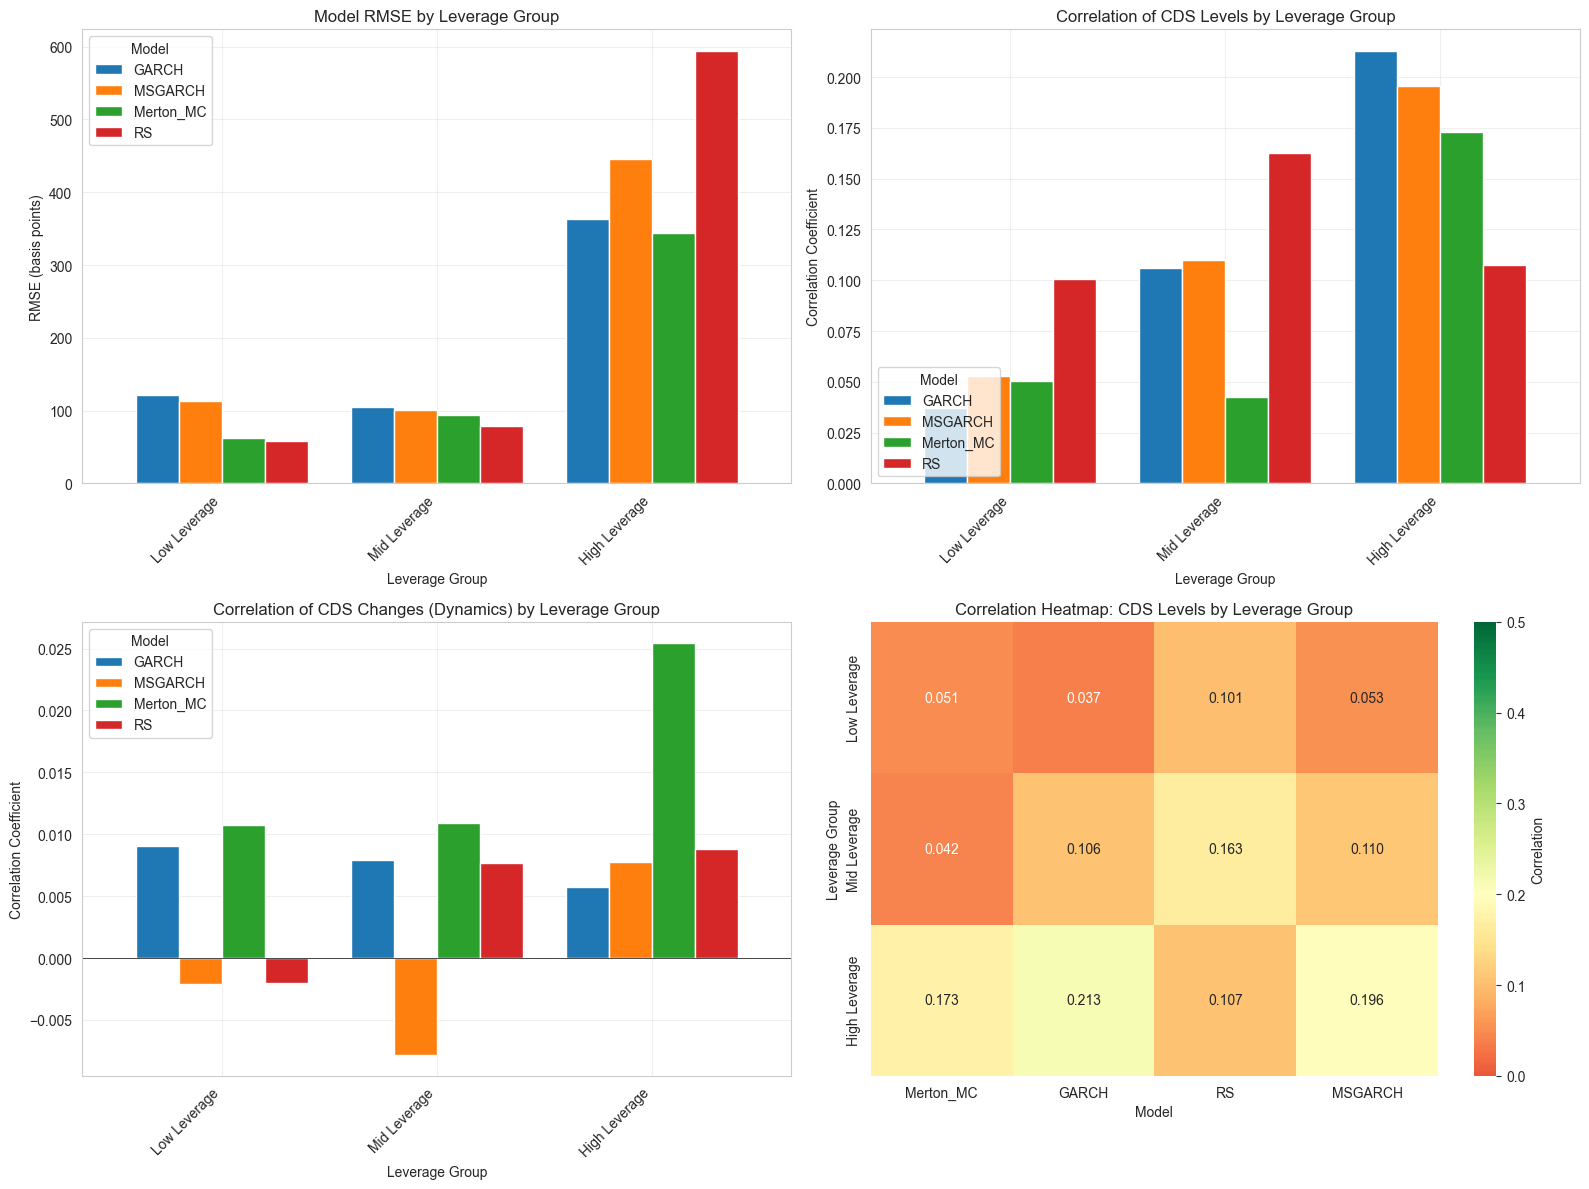

✓ Leverage group visualization complete


In [11]:
# Visualize correlations by leverage group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. RMSE by leverage group
ax1 = axes[0, 0]
leverage_rmse = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_rmse.append({
            'Leverage Group': group,
            'Model': model,
            'RMSE': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_rmse'].values[0]
        })
rmse_df = pd.DataFrame(leverage_rmse)
rmse_pivot = rmse_df.pivot(index='Leverage Group', columns='Model', values='RMSE')
rmse_pivot = rmse_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
rmse_pivot.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_ylabel('RMSE (basis points)')
ax1.set_title('Model RMSE by Leverage Group')
ax1.legend(title='Model', loc='upper left')
ax1.grid(True, alpha=0.3)
plt.sca(ax1)
plt.xticks(rotation=45, ha='right')

# 2. Correlation of Levels by leverage group
ax2 = axes[0, 1]
leverage_corr_lvl = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_corr_lvl.append({
            'Leverage Group': group,
            'Model': model,
            'Correlation': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_lvl'].values[0]
        })
corr_lvl_df = pd.DataFrame(leverage_corr_lvl)
corr_lvl_pivot = corr_lvl_df.pivot(index='Leverage Group', columns='Model', values='Correlation')
corr_lvl_pivot = corr_lvl_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
corr_lvl_pivot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_ylabel('Correlation Coefficient')
ax2.set_title('Correlation of CDS Levels by Leverage Group')
ax2.legend(title='Model', loc='lower left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.sca(ax2)
plt.xticks(rotation=45, ha='right')

# 3. Correlation of Changes by leverage group
ax3 = axes[1, 0]
leverage_corr_chg = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    for model in models:
        leverage_corr_chg.append({
            'Leverage Group': group,
            'Model': model,
            'Correlation': leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_chg'].values[0]
        })
corr_chg_df = pd.DataFrame(leverage_corr_chg)
corr_chg_pivot = corr_chg_df.pivot(index='Leverage Group', columns='Model', values='Correlation')
corr_chg_pivot = corr_chg_pivot.reindex(['Low Leverage', 'Mid Leverage', 'High Leverage'])
corr_chg_pivot.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_ylabel('Correlation Coefficient')
ax3.set_title('Correlation of CDS Changes (Dynamics) by Leverage Group')
ax3.legend(title='Model', loc='upper left')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.sca(ax3)
plt.xticks(rotation=45, ha='right')

# 4. Heatmap of correlations
ax4 = axes[1, 1]
# Create a matrix: rows = leverage groups, cols = models (for levels)
heatmap_data = []
for group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
    row_data = []
    for model in models:
        r_lvl = leverage_stats_df[leverage_stats_df['Leverage Group'] == group][f'{model}_r_lvl'].values[0]
        row_data.append(r_lvl)
    heatmap_data.append(row_data)

heatmap_df = pd.DataFrame(heatmap_data, 
                          index=['Low Leverage', 'Mid Leverage', 'High Leverage'],
                          columns=models)

sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.2,
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=0, vmax=0.5)
ax4.set_title('Correlation Heatmap: CDS Levels by Leverage Group')
ax4.set_xlabel('Model')
ax4.set_ylabel('Leverage Group')

plt.tight_layout()
plt.savefig(config.OUTPUT_DIR / 'cds_correlation_by_leverage.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Leverage group visualization complete")

In [12]:
# Display firm-level results within each leverage group
print("\n" + "="*100)
print("FIRM-LEVEL RESULTS BY LEVERAGE GROUP")
print("="*100)

for group in ['High Leverage', 'Mid Leverage', 'Low Leverage']:
    group_df = results_df[results_df['leverage_group'] == group].copy()
    
    if len(group_df) == 0:
        continue
    
    # Merge leverage ratio for display
    group_df = group_df.merge(
        firm_leverage[['gvkey', 'avg_leverage']], 
        on='gvkey', 
        how='left'
    )
    
    # Sort by best GARCH correlation (since it performs best overall)
    group_df = group_df.sort_values('GARCH_corr_lvl', ascending=False)
    
    print(f"\n{'-'*100}")
    print(f"{group.upper()} ({len(group_df)} firms)")
    print(f"{'-'*100}")
    print(f"{'Company':<40} {'Leverage':>8} | {'GARCH r_lvl':>10} {'GARCH r_chg':>10} | {'MS-GARCH r_lvl':>12} {'MS-GARCH r_chg':>12}")
    print(f"{'-'*100}")
    
    for _, row in group_df.iterrows():
        print(f"{row['company'][:39]:<40} {row['avg_leverage']:>7.2%} | "
              f"{row['GARCH_corr_lvl']:>10.3f} {row['GARCH_corr_chg']:>10.3f} | "
              f"{row['MSGARCH_corr_lvl']:>12.3f} {row['MSGARCH_corr_chg']:>12.3f}")

print("\n✓ Firm-level leverage group analysis complete")


FIRM-LEVEL RESULTS BY LEVERAGE GROUP

----------------------------------------------------------------------------------------------------
HIGH LEVERAGE (11 firms)
----------------------------------------------------------------------------------------------------
Company                                  Leverage | GARCH r_lvl GARCH r_chg | MS-GARCH r_lvl MS-GARCH r_chg
----------------------------------------------------------------------------------------------------
BNP PARIBAS                               97.06% |      0.577     -0.012 |        0.587       -0.042
AXA SA                                    93.43% |      0.492      0.007 |        0.473        0.018
ING GROEP NV                              95.79% |      0.491      0.007 |        0.515        0.012
ENEL SPA                                  72.35% |      0.372      0.021 |        0.327       -0.019
INTESA SANPAOLO SPA                       95.19% |      0.353      0.030 |        0.334        0.141
UNICREDIT SPA       

In [13]:
# Export leverage group analysis results
# 1. Export leverage group summary statistics
leverage_stats_df.to_csv(
    config.OUTPUT_DIR / 'cds_correlation_by_leverage_group.csv',
    index=False
)
print("✓ Exported: cds_correlation_by_leverage_group.csv")

# 2. Export firm-level results with leverage groups
results_with_leverage = results_df.merge(
    firm_leverage[['gvkey', 'avg_leverage', 'leverage_tercile']], 
    on='gvkey', 
    how='left'
)
results_with_leverage.to_csv(
    config.OUTPUT_DIR / 'cds_correlations_with_leverage.csv',
    index=False
)
print("✓ Exported: cds_correlations_with_leverage.csv")

print("\n" + "="*100)
print("LEVERAGE GROUP ANALYSIS SUMMARY")
print("="*100)
print(f"\nTotal firms analyzed: {len(results_df)}")
print(f"Leverage groups created: 3 (Low, Mid, High)")
print(f"\nKey findings:")
print(f"1. Check visualizations: leverage_analysis.png, cds_correlation_by_leverage.png")
print(f"2. Review detailed statistics in: cds_correlation_by_leverage_group.csv")
print(f"3. Full firm-level data with leverage in: cds_correlations_with_leverage.csv")
print(f"\n✓ Leverage group analysis complete!")

✓ Exported: cds_correlation_by_leverage_group.csv
✓ Exported: cds_correlations_with_leverage.csv

LEVERAGE GROUP ANALYSIS SUMMARY

Total firms analyzed: 34
Leverage groups created: 3 (Low, Mid, High)

Key findings:
1. Check visualizations: leverage_analysis.png, cds_correlation_by_leverage.png
2. Review detailed statistics in: cds_correlation_by_leverage_group.csv
3. Full firm-level data with leverage in: cds_correlations_with_leverage.csv

✓ Leverage group analysis complete!


### Key Questions Addressed by Leverage Group Analysis

**1. Do structural models perform better for specific leverage levels?**
   - Theory suggests Merton model works best for moderate leverage
   - Very low leverage: Less default risk, harder to calibrate
   - Very high leverage: Model assumptions may break down (distress, illiquidity)

**2. Which models handle high-leverage firms better?**
   - GARCH may capture volatility dynamics better in distress
   - MS-GARCH may detect regime switches in troubled firms
   - Classical Merton may struggle with extreme leverage

**3. Practical implications:**
   - Should we use different models for different leverage profiles?
   - Are CDS spreads for high-leverage firms harder to model?
   - Do volatility models (GARCH/MS-GARCH) add value for specific groups?

**Expected patterns:**
   - **Low leverage firms**: Better fit overall (less default risk, cleaner data)
   - **Mid leverage firms**: Best Merton performance (sweet spot for structural models)
   - **High leverage firms**: More noise, potential for regime-switching models to shine

Run the cells above to see if these hypotheses hold in the data!

## 4. Model Comparison: Which Model Performs Best?

Compare models using:
1. Steiger's Z-test for comparing dependent correlations
2. RMSE comparison
3. Win-loss records

In [14]:
# Which model has best correlation for each firm?
results_df['best_corr_lvl_model'] = results_df[[f'{m}_corr_lvl' for m in models]].idxmax(axis=1).str.replace('_corr_lvl', '')
results_df['best_corr_chg_model'] = results_df[[f'{m}_corr_chg' for m in models]].idxmax(axis=1).str.replace('_corr_chg', '')
results_df['best_rmse_model'] = results_df[[f'{m}_rmse' for m in models]].idxmin(axis=1).str.replace('_rmse', '')

print("="*80)
print("MODEL WIN-LOSS RECORDS (5Y Maturity)")
print("="*80)
print()

print("Best Correlation of LEVELS (# of firms):")
print(results_df['best_corr_lvl_model'].value_counts())
print()

print("Best Correlation of CHANGES (# of firms):")
print(results_df['best_corr_chg_model'].value_counts())
print()

print("Best RMSE (lowest error, # of firms):")
print(results_df['best_rmse_model'].value_counts())
print()

MODEL WIN-LOSS RECORDS (5Y Maturity)

Best Correlation of LEVELS (# of firms):
best_corr_lvl_model
Merton_MC    12
RS           11
GARCH         8
MSGARCH       3
Name: count, dtype: int64

Best Correlation of CHANGES (# of firms):
best_corr_chg_model
Merton_MC    15
RS           11
GARCH         7
MSGARCH       1
Name: count, dtype: int64

Best RMSE (lowest error, # of firms):
best_rmse_model
RS           22
MSGARCH       6
Merton_MC     4
GARCH         2
Name: count, dtype: int64



## 4B. Formal Statistical Tests for Model Comparison

Implement rigorous statistical tests:

1. **Diebold-Mariano (DM) Test**: Compare forecast accuracy (RMSE) between models
2. **Hotelling-Williams Test**: Compare overlapping correlations (dependent correlations)
3. **Combined Analysis**: Test both overall and by leverage groups

**References:**
- Diebold & Mariano (1995): Comparing Predictive Accuracy
- Hotelling (1940) & Williams (1959): Comparing dependent correlations
- Steiger (1980): Tests for comparing elements of a correlation matrix

In [15]:
def diebold_mariano_test(errors1, errors2, h=1):
    """
    Diebold-Mariano test for comparing forecast accuracy.
    
    Tests H0: E[g(e1)] = E[g(e2)] where g is the loss function (squared error).
    
    Parameters:
    -----------
    errors1 : array-like
        Forecast errors from model 1 (actual - predicted1)
    errors2 : array-like
        Forecast errors from model 2 (actual - predicted2)
    h : int
        Forecast horizon (default 1 for one-step-ahead)
    
    Returns:
    --------
    dict with DM statistic, p-value, and interpretation
    
    References:
    -----------
    Diebold, F. X., & Mariano, R. S. (1995). Comparing predictive accuracy.
    Journal of Business & Economic Statistics, 13(3), 253-263.
    """
    errors1 = np.array(errors1)
    errors2 = np.array(errors2)
    
    # Loss differential: d_t = g(e1_t) - g(e2_t) where g(e) = e^2 (squared error)
    d = errors1**2 - errors2**2
    
    # Mean loss differential
    d_bar = np.mean(d)
    
    # Number of observations
    T = len(d)
    
    # Variance of d (accounting for autocorrelation)
    # For h-step ahead forecasts, use Newey-West standard errors
    gamma_0 = np.var(d, ddof=1)
    
    # Simple case (h=1): no autocorrelation adjustment needed for daily data
    if h == 1:
        var_d = gamma_0 / (T-1)
    else:
        # Newey-West for h > 1
        gamma_sum = 0
        for j in range(1, h):
            if j < T:
                gamma_j = np.cov(d[:-j], d[j:])[0, 1]
                gamma_sum += 2 * gamma_j
        var_d = (gamma_0 + gamma_sum) / (T-1)
    
    # DM statistic
    DM = d_bar / np.sqrt(var_d)
    
    # P-value (two-tailed test, approximately standard normal for large T)
    p_value = 2 * (1 - stats.norm.cdf(abs(DM)))
    
    # Interpretation
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    # Which model is better?
    if DM > 0:
        better_model = 'Model 2 (lower RMSE)'
    elif DM < 0:
        better_model = 'Model 1 (lower RMSE)'
    else:
        better_model = 'No difference'
    
    return {
        'DM_stat': DM,
        'p_value': p_value,
        'significance': sig,
        'better_model': better_model,
        'mean_loss_diff': d_bar
    }

print("✓ Diebold-Mariano test function defined")

✓ Diebold-Mariano test function defined


In [16]:
def hotelling_williams_test(r12, r13, r23, n):
    """
    Hotelling-Williams test for comparing two dependent correlations.
    
    Tests whether correlation r12 is significantly different from r13,
    where both correlations share variable 1 (overlapping/dependent correlations).
    
    H0: ρ12 = ρ13  vs  H1: ρ12 ≠ ρ13
    
    Parameters:
    -----------
    r12 : float
        Correlation between variable 1 and 2 (e.g., market CDS vs model A)
    r13 : float
        Correlation between variable 1 and 3 (e.g., market CDS vs model B)
    r23 : float
        Correlation between variable 2 and 3 (e.g., model A vs model B)
    n : int
        Sample size
    
    Returns:
    --------
    dict with t-statistic, p-value, and interpretation
    
    References:
    -----------
    Hotelling, H. (1940). The selection of variates for use in prediction.
    Williams, E. J. (1959). The comparison of regression variables.
    Steiger, J. H. (1980). Tests for comparing elements of a correlation matrix.
    """
    # Avoid division by zero
    if abs(1 - r23) < 1e-10:
        return {
            't_stat': np.nan,
            'p_value': np.nan,
            'significance': '',
            'interpretation': 'Models too highly correlated (r23 ≈ 1)'
        }
    
    # Average correlation
    r_bar = (r12 + r13) / 2
    
    # Determinant term
    det = 1 - r12**2 - r13**2 - r23**2 + 2*r12*r13*r23
    
    if det <= 0:
        return {
            't_stat': np.nan,
            'p_value': np.nan,
            'significance': '',
            'interpretation': 'Invalid correlation matrix (det ≤ 0)'
        }
    
    # Hotelling-Williams t-statistic
    numerator = (r12 - r13) * np.sqrt((n - 1)*(1 + r23))
    denominator = np.sqrt(2 * (n - 1)/(n - 3) * det + r_bar**2 * (1 - r23)**3)
    
    t_HW = numerator / denominator
    
    # Degrees of freedom
    df = n - 3
    
    # P-value (two-tailed)
    p_value = 2 * (1 - stats.t.cdf(abs(t_HW), df=df))
    
    # Significance
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    # Interpretation
    if p_value < 0.05:
        if r12 > r13:
            interpretation = f'r12 ({r12:.3f}) significantly > r13 ({r13:.3f})'
        else:
            interpretation = f'r13 ({r13:.3f}) significantly > r12 ({r12:.3f})'
    else:
        interpretation = f'No significant difference between r12 ({r12:.3f}) and r13 ({r13:.3f})'
    
    return {
        't_stat': t_HW,
        'df': df,
        'p_value': p_value,
        'significance': sig,
        'interpretation': interpretation
    }

print("✓ Hotelling-Williams test function defined")

✓ Hotelling-Williams test function defined


### 4B.1 Overall Model Comparison (All Firms Combined)

Test if model performance differences are statistically significant across all firms.

In [17]:
# Load the full matched CDS data to compute errors for DM test
# We'll load ALL maturities (1y, 3y, 5y) for comprehensive analysis

print("Loading model CDS spread files for all maturities...")

# ====================
# LOAD MODEL SPREADS
# ====================

# Merton analytical spreads
merton_df = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_merton_analytical.csv')
merton_df['date'] = pd.to_datetime(merton_df['date'])

# Merton MC spreads (constant volatility baseline)
merton_mc_df = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_merton_mc_all_firms.csv')
merton_mc_df['date'] = pd.to_datetime(merton_mc_df['date'])

# GARCH Monte Carlo spreads
garch_df = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv')
garch_df['date'] = pd.to_datetime(garch_df['date'])

# Regime-Switching Monte Carlo spreads
rs_df = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv')
rs_df['date'] = pd.to_datetime(rs_df['date'])

# MS-GARCH Monte Carlo spreads
msgarch_df = pd.read_csv(config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv')
msgarch_df['date'] = pd.to_datetime(msgarch_df['date'])

print(f"✓ Loaded Merton: {len(merton_df)} observations")
print(f"✓ Loaded Merton MC: {len(merton_mc_df)} observations")
print(f"✓ Loaded GARCH: {len(garch_df)} observations")
print(f"✓ Loaded RS: {len(rs_df)} observations")
print(f"✓ Loaded MS-GARCH: {len(msgarch_df)} observations")

# ====================
# LOAD MARKET CDS DATA
# ====================

def load_cds_market_data(filepath, maturity):
    """Load CDS market data from Excel file."""
    df = pd.read_excel(filepath, header=None)
    
    # Row 3 has company names, data starts at row 5
    company_names_raw = df.iloc[3, 2:].tolist()
    company_names = []
    for name in company_names_raw:
        if pd.notna(name):
            clean = name.split(' SNR ')[0] if ' SNR ' in str(name) else str(name)
            company_names.append(clean)
        else:
            company_names.append(None)
    
    # Get dates and data
    dates = pd.to_datetime(df.iloc[5:, 0], errors='coerce')
    data = df.iloc[5:, 2:].copy()
    data.columns = company_names[:len(data.columns)]
    data['date'] = dates.values
    
    # Melt to long format
    data_long = data.melt(
        id_vars=['date'], 
        var_name='company_cds', 
        value_name=f'cds_market_{maturity}y_bps'
    )
    data_long[f'cds_market_{maturity}y_bps'] = pd.to_numeric(
        data_long[f'cds_market_{maturity}y_bps'], errors='coerce'
    )
    
    return data_long

# Company name mapping between market CDS names and model names
COMPANY_MAPPING = {
    'ADIDAS AG': 'ADIDAS AG',
    'AIRBUS GROUP SE': 'AIRBUS SE',
    'ALLIANZ SE': 'ALLIANZ SE',
    'ANHEUSER-BUSCH INBEV': 'ANHEUSER-BUSCH',
    'AXA SA': 'AXA',
    'BASF SE': 'BASF SE',
    'BAYER AG': 'BAYER AG',
    'BAYERISCHE MOTOREN WERKE AKT': 'BAYER MOTOREN WERKE',
    'BNP PARIBAS': 'BNP PARIBAS SA',
    'DANONE SA': 'DANONE SA',
    'DEUTSCHE POST AG': 'DEUTSCHE POST AG',
    'DEUTSCHE TELEKOM': 'DEUTSCHE TELEKOM AG',
    'ENEL SPA': 'ENEL S.P.A.',
    'ENI SPA': 'ENI S.P.A.',
    'IBERDROLA SA': 'IBERDROLA, S.A.',
    'INFINEON TECHNOLOGIES AG': 'INFINEON TECS',
    'ING GROEP NV': 'ING GROEP N.V.',
    'INTESA SANPAOLO SPA': 'INTESA SANPAOLO',
    'KERING SA': 'KERING SA',
    'KONINKLIJKE AHOLD DELHAIZE': 'KON AHOLD DELHAIZE',
    "L'AIR LIQUIDE SA": 'AIR LIQUIDE SA',
    'LOREAL SA': "L'OREAL",
    'LVMH MOET HENNESSY LOUIS V': 'LVMH MOET HENNESSY',
    'MUNICH RE CO': 'MUNICH REINSURANCE',
    'NOKIA OYJ': 'NOKIA OYJ',
    'ORANGE SA': 'ORANGE S.A.',
    'SANOFI': 'SANOFI SA',
    'SAP SE': 'SAP SE',
    'SCHNEIDER ELECTRIC S E': 'SCHNEIDER ELECTRIC',
    'SIEMENS AG': 'SIEMENS AG',
    'TOTALENERGIES SE': 'TOTALENERGIES SE',
    'UNICREDIT SPA': 'UNICREDIT SPA',
    'VINCI SA': 'VINCI',
    'WOLTERS KLUWER NV': 'WOLTERS KLUWER NV',
}

print("\nLoading market CDS data for all maturities...")
input_dir = config.DATA_DIR / 'input'

# Load market CDS for all maturities
cds_1y = load_cds_market_data(input_dir / 'CDS_1y_mat_data.xlsx', 1)
cds_3y = load_cds_market_data(input_dir / 'CDS_3y_mat_data.xlsx', 3)
cds_5y = load_cds_market_data(input_dir / 'CDS_5y_mat_data.xlsx', 5)

# Merge all maturities
market_df = cds_1y.merge(cds_3y, on=['date', 'company_cds'], how='outer')
market_df = market_df.merge(cds_5y, on=['date', 'company_cds'], how='outer')

# Add company name mapping
company_to_gvkey = df_merged[['company', 'gvkey']].drop_duplicates()
reverse_mapping = {cds_name: model_name for model_name, cds_name in COMPANY_MAPPING.items()}
market_df['company'] = market_df['company_cds'].map(reverse_mapping)

# Merge with gvkey
market_df = market_df.merge(company_to_gvkey, on='company', how='left')
market_df = market_df.dropna(subset=['gvkey'])

print(f"✓ Loaded market CDS: {len(market_df)} observations")
print(f"  - Unique firms: {market_df['gvkey'].nunique()}")
print(f"  - Date range: {market_df['date'].min()} to {market_df['date'].max()}")

# ====================
# MERGE ALL DATA
# ====================

print("\nMerging model and market data...")
merge_keys = ['date', 'gvkey']

# Start with market data as base
cds_comparison = market_df[merge_keys + ['cds_market_1y_bps', 'cds_market_3y_bps', 'cds_market_5y_bps']].copy()

# Convert market spreads from bps to decimal
cds_comparison['market_1y'] = cds_comparison['cds_market_1y_bps'] / 10000
cds_comparison['market_3y'] = cds_comparison['cds_market_3y_bps'] / 10000
cds_comparison['market_5y'] = cds_comparison['cds_market_5y_bps'] / 10000

# Merge Merton (all maturities)
merton_cols = merge_keys + ['cds_spread_merton_1y', 'cds_spread_merton_3y', 'cds_spread_merton_5y']
cds_comparison = cds_comparison.merge(
    merton_df[merton_cols],
    on=merge_keys,
    how='inner'
)

# Merge Merton MC (all maturities)
merton_mc_cols = merge_keys + ['cds_spread_merton_mc_1y', 'cds_spread_merton_mc_3y', 'cds_spread_merton_mc_5y']
cds_comparison = cds_comparison.merge(
    merton_mc_df[merton_mc_cols],
    on=merge_keys,
    how='inner'
)

# Merge GARCH (all maturities)
garch_cols = merge_keys + ['cds_spread_garch_mc_1y', 'cds_spread_garch_mc_3y', 'cds_spread_garch_mc_5y']
cds_comparison = cds_comparison.merge(
    garch_df[garch_cols],
    on=merge_keys,
    how='inner'
)

# Merge RS (all maturities)
rs_cols = merge_keys + ['cds_spread_regime_switching_mc_1y', 'cds_spread_regime_switching_mc_3y', 'cds_spread_regime_switching_mc_5y']
cds_comparison = cds_comparison.merge(
    rs_df[rs_cols],
    on=merge_keys,
    how='inner'
)

# Merge MS-GARCH (all maturities)
msgarch_cols = merge_keys + ['cds_spread_msgarch_mc_1y', 'cds_spread_msgarch_mc_3y', 'cds_spread_msgarch_mc_5y']
cds_comparison = cds_comparison.merge(
    msgarch_df[msgarch_cols],
    on=merge_keys,
    how='inner'
)

print(f"✓ Merged all models: {len(cds_comparison)} matched observations")
print(f"  - Date range: {cds_comparison['date'].min()} to {cds_comparison['date'].max()}")
print(f"  - Number of firms: {cds_comparison['gvkey'].nunique()}")

# ====================
# COMPUTE ERRORS FOR EACH MATURITY
# ====================

print("\nComputing forecast errors for each maturity...")

# Rename model columns for clarity
cds_comparison = cds_comparison.rename(columns={
    'cds_spread_merton_1y': 'merton_1y',
    'cds_spread_merton_3y': 'merton_3y',
    'cds_spread_merton_5y': 'merton_5y',
    'cds_spread_merton_mc_1y': 'merton_mc_1y',
    'cds_spread_merton_mc_3y': 'merton_mc_3y',
    'cds_spread_merton_mc_5y': 'merton_mc_5y',
    'cds_spread_garch_mc_1y': 'garch_1y',
    'cds_spread_garch_mc_3y': 'garch_3y',
    'cds_spread_garch_mc_5y': 'garch_5y',
    'cds_spread_regime_switching_mc_1y': 'rs_1y',
    'cds_spread_regime_switching_mc_3y': 'rs_3y',
    'cds_spread_regime_switching_mc_5y': 'rs_5y',
    'cds_spread_msgarch_mc_1y': 'msgarch_1y',
    'cds_spread_msgarch_mc_3y': 'msgarch_3y',
    'cds_spread_msgarch_mc_5y': 'msgarch_5y',
})

# Compute errors for each model and maturity (error = actual - predicted)
models = ['merton', 'merton_mc', 'garch', 'rs', 'msgarch']
maturities = ['1y', '3y', '5y']

for maturity in maturities:
    for model in models:
        model_col = f'{model}_{maturity}'
        market_col = f'market_{maturity}'
        error_col = f'error_{model}_{maturity}'
        cds_comparison[error_col] = cds_comparison[market_col] - cds_comparison[model_col]

# Remove rows with any missing values
required_cols = []
for maturity in maturities:
    required_cols.extend([f'market_{maturity}'] + [f'{model}_{maturity}' for model in models])

cds_comparison = cds_comparison.dropna(subset=required_cols)

print(f"✓ After removing NaN: {len(cds_comparison)} observations")
print(f"\nSummary statistics by maturity:")

for maturity in maturities:
    mat_cols = [f'market_{maturity}', f'merton_{maturity}', f'merton_mc_{maturity}', f'garch_{maturity}', 
                f'rs_{maturity}', f'msgarch_{maturity}']
    print(f"\n{maturity.upper()} Maturity:")
    print(cds_comparison[mat_cols].describe())

print(f"\n✓ Ready for Diebold-Mariano and Hotelling-Williams tests")
print(f"✓ Data prepared for all three maturities: 1Y, 3Y, 5Y")
print(f"✓ Models included: Merton (analytical), Merton MC (baseline), GARCH, RS, MS-GARCH")

cds_comparison.head()

Loading model CDS spread files for all maturities...


✓ Loaded Merton: 127942 observations
✓ Loaded Merton MC: 127908 observations
✓ Loaded GARCH: 127908 observations
✓ Loaded RS: 127908 observations
✓ Loaded MS-GARCH: 127908 observations

Loading market CDS data for all maturities...


/var/folders/lw/gs7_mtq5055_nlg18qdq3g540000gn/T/ipykernel_34422/893176057.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(df.iloc[5:, 0], errors='coerce')
/var/folders/lw/gs7_mtq5055_nlg18qdq3g540000gn/T/ipykernel_34422/893176057.py:55: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dates = pd.to_datetime(df.iloc[5:, 0], errors='coerce')


✓ Loaded market CDS: 137772 observations
  - Unique firms: 33
  - Date range: 2010-01-01 00:00:00 to 2025-12-31 00:00:00

Merging model and market data...
✓ Merged all models: 124146 matched observations
  - Date range: 2010-08-02 00:00:00 to 2024-12-31 00:00:00
  - Number of firms: 33

Computing forecast errors for each maturity...
✓ After removing NaN: 106381 observations

Summary statistics by maturity:

1Y Maturity:
           market_1y     merton_1y  merton_mc_1y      garch_1y         rs_1y  \
count  106381.000000  1.063810e+05  1.063810e+05  1.063810e+05  1.063810e+05   
mean        0.002418  2.036734e-02  1.976756e-02  2.209196e-02  2.809660e-02   
std         0.003178  1.309133e-01  1.268084e-01  1.299361e-01  1.351235e-01   
min         0.000159 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
25%         0.000923  1.110223e-16  0.000000e+00  2.112976e-12  2.832179e-13   
50%         0.001347  8.346401e-11  2.142464e-11  1.777509e-07  2.223620e-08   
75%         0.00

,date,gvkey,cds_market_1y_bps,cds_market_3y_bps,cds_market_5y_bps,market_1y,market_3y,market_5y,merton_1y,merton_3y,...,error_merton_3y,error_merton_mc_3y,error_garch_3y,error_rs_3y,error_msgarch_3y,error_merton_5y,error_merton_mc_5y,error_garch_5y,error_rs_5y,error_msgarch_5y
1,2010-08-02,101202.0,29.37000,43.62999,53.67000,0.002937,0.004363,0.005367,1.111022e-11,3.903318e-06,...,0.004359,0.004363,0.004363,0.004363,0.004363,0.005314,0.005363,0.005367,0.005367,0.005362
2,2010-08-02,15724.0,17.20000,39.35999,53.87000,0.001720,0.003936,0.005387,8.289591e-09,2.251002e-07,...,0.003936,0.003936,0.003925,0.003834,-0.001574,0.005387,0.005387,0.005378,0.005304,0.001019
4,2010-08-02,63120.0,52.60999,74.42000,92.59000,0.005261,0.007442,0.009259,6.125648e-05,6.479824e-05,...,0.007377,0.007360,0.004692,-0.067029,0.003726,0.009223,0.009211,0.007262,-0.049797,0.006527
5,2010-08-02,17436.0,45.64999,60.71999,70.95999,0.004565,0.006072,0.007096,1.391577e-09,1.802886e-05,...,0.006054,0.006072,0.005572,0.006071,0.006051,0.006973,0.007095,0.005748,0.007078,0.006958
6,2010-08-02,100080.0,37.65999,51.75999,63.12000,0.003766,0.005176,0.006312,4.021683e-11,4.304100e-06,...,0.005172,0.005171,0.003438,0.005041,0.005076,0.006267,0.006263,0.002887,0.005792,0.005892


In [18]:
# Diebold-Mariano Test: Pairwise model comparisons for ALL maturities
print("="*120)
print("DIEBOLD-MARIANO TESTS: OVERALL (All Firms, All Maturities)")
print("="*120)
print("\nComparing forecast accuracy (RMSE) between model pairs")
print("H0: Models have equal forecast accuracy")
print("H1: Models have different forecast accuracy")
print()

model_pairs = [
    ('garch', 'merton'),
    ('garch', 'merton_mc'),
    ('garch', 'rs'),
    ('garch', 'msgarch'),
    ('msgarch', 'merton'),
    ('msgarch', 'merton_mc'),
    ('msgarch', 'rs'),
    ('merton', 'merton_mc'),
    ('merton', 'rs'),
    ('merton_mc', 'rs')
]

maturities = ['1y', '3y', '5y']
dm_results_overall = []

for maturity in maturities:
    print(f"\n{'='*120}")
    print(f"MATURITY: {maturity.upper()}")
    print(f"{'='*120}\n")
    
    for model1, model2 in model_pairs:
        errors1 = cds_comparison[f'error_{model1}_{maturity}'].values
        errors2 = cds_comparison[f'error_{model2}_{maturity}'].values
        
        dm_test = diebold_mariano_test(errors1, errors2, h=1)
        
        print(f"{model1.upper()} vs {model2.upper()}:")
        print(f"  DM statistic: {dm_test['DM_stat']:8.4f}")
        print(f"  p-value:      {dm_test['p_value']:.4e} {dm_test['significance']}")
        print(f"  Result:       {dm_test['better_model']}")
        print()
        
        dm_results_overall.append({
            'maturity': maturity,
            'model1': model1,
            'model2': model2,
            'DM_stat': dm_test['DM_stat'],
            'p_value': dm_test['p_value'],
            'significance': dm_test['significance'],
            'result': dm_test['better_model']
        })

dm_overall_df = pd.DataFrame(dm_results_overall)
print(f"\n✓ Completed {len(dm_results_overall)} Diebold-Mariano tests (all maturities)")

DIEBOLD-MARIANO TESTS: OVERALL (All Firms, All Maturities)

Comparing forecast accuracy (RMSE) between model pairs
H0: Models have equal forecast accuracy
H1: Models have different forecast accuracy


MATURITY: 1Y

GARCH vs MERTON:
  DM statistic:  -1.2879
  p-value:      1.9778e-01 
  Result:       Model 1 (lower RMSE)

GARCH vs MERTON_MC:
  DM statistic:   8.2471
  p-value:      2.2204e-16 ***
  Result:       Model 2 (lower RMSE)

GARCH vs RS:
  DM statistic: -11.5411
  p-value:      0.0000e+00 ***
  Result:       Model 1 (lower RMSE)

GARCH vs MSGARCH:
  DM statistic: -23.5266
  p-value:      0.0000e+00 ***
  Result:       Model 1 (lower RMSE)

MSGARCH vs MERTON:
  DM statistic:  23.0254
  p-value:      0.0000e+00 ***
  Result:       Model 2 (lower RMSE)

MSGARCH vs MERTON_MC:
  DM statistic:  27.5038
  p-value:      0.0000e+00 ***
  Result:       Model 2 (lower RMSE)

MSGARCH vs RS:
  DM statistic:  17.8564
  p-value:      0.0000e+00 ***
  Result:       Model 2 (lower RMSE)

MERTON

In [19]:
# Hotelling-Williams Test: Comparing correlations with market CDS for ALL maturities
print("\n" + "="*120)
print("HOTELLING-WILLIAMS TESTS: OVERALL (All Firms, All Maturities)")
print("="*120)
print("\nComparing correlations of CDS LEVELS with market spreads")
print("H0: Two models have equal correlation with market")
print("H1: Models have different correlations with market")
print()

maturities = ['1y', '3y', '5y']
hw_results_overall = []

for maturity in maturities:
    print(f"\n{'='*120}")
    print(f"MATURITY: {maturity.upper()}")
    print(f"{'='*120}\n")
    
    # Compute all correlations for this maturity
    market_col = f'market_{maturity}'
    
    # Correlations between market and each model
    r_market_merton = pearsonr(cds_comparison[market_col].values, 
                                cds_comparison[f'merton_{maturity}'].values)[0]
    r_market_garch = pearsonr(cds_comparison[market_col].values, 
                              cds_comparison[f'garch_{maturity}'].values)[0]
    r_market_rs = pearsonr(cds_comparison[market_col].values, 
                           cds_comparison[f'rs_{maturity}'].values)[0]
    r_market_msgarch = pearsonr(cds_comparison[market_col].values, 
                                cds_comparison[f'msgarch_{maturity}'].values)[0]
    
    # Correlations between models (needed for HW test)
    r_merton_garch = pearsonr(cds_comparison[f'merton_{maturity}'].values, 
                             cds_comparison[f'garch_{maturity}'].values)[0]
    r_merton_rs = pearsonr(cds_comparison[f'merton_{maturity}'].values, 
                          cds_comparison[f'rs_{maturity}'].values)[0]
    r_merton_msgarch = pearsonr(cds_comparison[f'merton_{maturity}'].values, 
                                cds_comparison[f'msgarch_{maturity}'].values)[0]
    r_garch_rs = pearsonr(cds_comparison[f'garch_{maturity}'].values, 
                         cds_comparison[f'rs_{maturity}'].values)[0]
    r_garch_msgarch = pearsonr(cds_comparison[f'garch_{maturity}'].values, 
                              cds_comparison[f'msgarch_{maturity}'].values)[0]
    r_rs_msgarch = pearsonr(cds_comparison[f'rs_{maturity}'].values, 
                           cds_comparison[f'msgarch_{maturity}'].values)[0]
    
    n_obs = len(cds_comparison)
    
    print(f"Sample size: n = {n_obs}")
    print()
    print("Correlations with Market CDS:")
    print(f"  Merton:    r = {r_market_merton:.4f}")
    print(f"  GARCH:     r = {r_market_garch:.4f}")
    print(f"  RS:        r = {r_market_rs:.4f}")
    print(f"  MS-GARCH:  r = {r_market_msgarch:.4f}")
    print()
    
    # Pairwise comparisons using Hotelling-Williams
    hw_comparisons = [
        ('GARCH', 'Merton', r_market_garch, r_market_merton, r_merton_garch),
        ('GARCH', 'RS', r_market_garch, r_market_rs, r_garch_rs),
        ('GARCH', 'MSGARCH', r_market_garch, r_market_msgarch, r_garch_msgarch),
        ('MSGARCH', 'Merton', r_market_msgarch, r_market_merton, r_merton_msgarch),
        ('MSGARCH', 'RS', r_market_msgarch, r_market_rs, r_rs_msgarch),
        ('Merton', 'RS', r_market_merton, r_market_rs, r_merton_rs)
    ]
    
    for model1, model2, r12, r13, r23 in hw_comparisons:
        hw_test = hotelling_williams_test(r12, r13, r23, n_obs)
        
        print(f"{model1} vs {model2}:")
        print(f"  t-statistic:  {hw_test['t_stat']:8.4f} (df = {hw_test['df']})")
        print(f"  p-value:      {hw_test['p_value']:.4e} {hw_test['significance']}")
        print(f"  Result:       {hw_test['interpretation']}")
        print()
        
        hw_results_overall.append({
            'Maturity': maturity,
            'Model_1': model1,
            'Model_2': model2,
            'r_market_model1': r12,
            'r_market_model2': r13,
            't_HW': hw_test['t_stat'],
            'df': hw_test['df'],
            'p_value': hw_test['p_value'],
            'Significance': hw_test['significance']
        })

# Create summary table
hw_overall_df = pd.DataFrame(hw_results_overall)

print("\n" + "="*120)
print("SUMMARY TABLE: Hotelling-Williams Tests (Overall, All Maturities)")
print("="*120)

# Display by maturity
for maturity in maturities:
    mat_df = hw_overall_df[hw_overall_df['Maturity'] == maturity]
    print(f"\n{maturity.upper()} MATURITY:")
    print(mat_df[['Model_1', 'Model_2', 'r_market_model1', 'r_market_model2', 
                  't_HW', 'p_value', 'Significance']].to_string(index=False))

print("\n" + "="*120)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05")
print("Interpretation: Tests whether correlations with market are significantly different between models")
print("="*120)


HOTELLING-WILLIAMS TESTS: OVERALL (All Firms, All Maturities)

Comparing correlations of CDS LEVELS with market spreads
H0: Two models have equal correlation with market
H1: Models have different correlations with market


MATURITY: 1Y

Sample size: n = 106381

Correlations with Market CDS:
  Merton:    r = 0.2293
  GARCH:     r = 0.2392
  RS:        r = 0.2336
  MS-GARCH:  r = 0.2187

GARCH vs Merton:
  t-statistic:   11.7354 (df = 106378)
  p-value:      0.0000e+00 ***
  Result:       r12 (0.239) significantly > r13 (0.229)

GARCH vs RS:
  t-statistic:    5.0298 (df = 106378)
  p-value:      4.9187e-07 ***
  Result:       r12 (0.239) significantly > r13 (0.234)

GARCH vs MSGARCH:
  t-statistic:   14.4340 (df = 106378)
  p-value:      0.0000e+00 ***
  Result:       r12 (0.239) significantly > r13 (0.219)

MSGARCH vs Merton:
  t-statistic:   -7.0705 (df = 106378)
  p-value:      1.5536e-12 ***
  Result:       r13 (0.229) significantly > r12 (0.219)

MSGARCH vs RS:
  t-statistic:   -9.

### 4B.2 Model Comparison by Leverage Groups

Test if model performance differences vary across leverage groups.

**Key Questions:**
- Do models perform significantly differently within low/mid/high leverage groups?
- Does the "best" model change across leverage levels?
- Are differences statistically significant or just sampling variation?

In [20]:
# Merge leverage groups into the full CDS comparison data
cds_comparison = cds_comparison.merge(
    firm_leverage[['gvkey', 'leverage_tercile']],
    on='gvkey',
    how='left'
)

print(f"Merged leverage groups into CDS data")
print(f"Observations per leverage group:")
print(cds_comparison['leverage_tercile'].value_counts())
print()

# Rename for consistency
cds_comparison['leverage_group'] = cds_comparison['leverage_tercile']
cds_comparison = cds_comparison.dropna(subset=['leverage_group'])

print(f"Final dataset: {len(cds_comparison)} observations with leverage groups")

Merged leverage groups into CDS data
Observations per leverage group:
leverage_tercile
Low Leverage     41151
Mid Leverage     32615
High Leverage    32615
Name: count, dtype: int64

Final dataset: 106381 observations with leverage groups


In [21]:
# Diebold-Mariano Tests by Leverage Group (All Maturities)
print("="*120)
print("DIEBOLD-MARIANO TESTS BY LEVERAGE GROUP (All Maturities)")
print("="*120)
print()

model_pairs = [
    ('garch', 'merton'),
    ('garch', 'merton_mc'),
    ('garch', 'rs'),
    ('garch', 'msgarch'),
    ('msgarch', 'merton'),
    ('msgarch', 'merton_mc'),
    ('msgarch', 'rs'),
    ('merton', 'merton_mc'),
    ('merton', 'rs'),
    ('merton_mc', 'rs')
]

maturities = ['1y', '3y', '5y']
dm_results_by_leverage = []

for maturity in maturities:
    print(f"\n{'='*120}")
    print(f"MATURITY: {maturity.upper()}")
    print(f"{'='*120}\n")
    
    for leverage_group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
        group_data = cds_comparison[cds_comparison['leverage_group'] == leverage_group]
        
        if len(group_data) < 30:  # Skip if too few observations
            print(f"Skipping {leverage_group}: insufficient observations (n={len(group_data)})")
            continue
        
        print(f"\n{'-'*120}")
        print(f"{leverage_group.upper()} (n = {len(group_data)} observations)")
        print(f"{'-'*120}\n")
        
        for model1, model2 in model_pairs:
            errors1 = group_data[f'error_{model1}_{maturity}'].values
            errors2 = group_data[f'error_{model2}_{maturity}'].values
            
            dm_test = diebold_mariano_test(errors1, errors2, h=1)
            
            print(f"{model1.upper()} vs {model2.upper()}:")
            print(f"  DM statistic: {dm_test['DM_stat']:8.4f}")
            print(f"  p-value:      {dm_test['p_value']:.4e} {dm_test['significance']}")
            print(f"  Result:       {dm_test['better_model']}")
            print()
            
            dm_results_by_leverage.append({
                'maturity': maturity,
                'leverage_group': leverage_group,
                'model1': model1,
                'model2': model2,
                'n_obs': len(group_data),
                'DM_stat': dm_test['DM_stat'],
                'p_value': dm_test['p_value'],
                'significance': dm_test['significance'],
                'result': dm_test['better_model']
            })

dm_leverage_df = pd.DataFrame(dm_results_by_leverage)
print(f"\n✓ Completed {len(dm_results_by_leverage)} Diebold-Mariano tests across leverage groups and maturities")

DIEBOLD-MARIANO TESTS BY LEVERAGE GROUP (All Maturities)


MATURITY: 1Y


------------------------------------------------------------------------------------------------------------------------
LOW LEVERAGE (n = 41151 observations)
------------------------------------------------------------------------------------------------------------------------

GARCH vs MERTON:
  DM statistic:   5.0281
  p-value:      4.9541e-07 ***
  Result:       Model 2 (lower RMSE)

GARCH vs MERTON_MC:
  DM statistic:   5.0260
  p-value:      5.0080e-07 ***
  Result:       Model 2 (lower RMSE)

GARCH vs RS:
  DM statistic:   5.0284
  p-value:      4.9447e-07 ***
  Result:       Model 2 (lower RMSE)

GARCH vs MSGARCH:
  DM statistic:   0.0814
  p-value:      9.3514e-01 
  Result:       Model 2 (lower RMSE)

MSGARCH vs MERTON:
  DM statistic:   7.3676
  p-value:      1.7386e-13 ***
  Result:       Model 2 (lower RMSE)

MSGARCH vs MERTON_MC:
  DM statistic:   7.3644
  p-value:      1.7786e-13 ***
  Result:    

In [22]:
# Hotelling-Williams Tests by Leverage Group (All Maturities)
print("="*120)
print("HOTELLING-WILLIAMS TESTS BY LEVERAGE GROUP (All Maturities)")
print("="*120)
print()

maturities = ['1y', '3y', '5y']
hw_results_by_leverage = []

for maturity in maturities:
    print(f"\n{'='*120}")
    print(f"MATURITY: {maturity.upper()}")
    print(f"{'='*120}\n")
    
    for leverage_group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
        group_data = cds_comparison[cds_comparison['leverage_group'] == leverage_group]
        
        if len(group_data) < 30:  # Skip if too few observations
            print(f"Skipping {leverage_group}: insufficient observations (n={len(group_data)})")
            continue
        
        print(f"\n{'#'*120}")
        print(f"# {leverage_group.upper()} - {maturity.upper()} (n={len(group_data)} observations)")
        print(f"{'#'*120}")
        print()
        
        # Compute correlations for this leverage group and maturity
        market_col = f'market_{maturity}'
        n_group = len(group_data)
        
        r_mkt_merton = pearsonr(group_data[market_col].values, 
                               group_data[f'merton_{maturity}'].values)[0]
        r_mkt_garch = pearsonr(group_data[market_col].values, 
                              group_data[f'garch_{maturity}'].values)[0]
        r_mkt_rs = pearsonr(group_data[market_col].values, 
                           group_data[f'rs_{maturity}'].values)[0]
        r_mkt_msgarch = pearsonr(group_data[market_col].values, 
                                group_data[f'msgarch_{maturity}'].values)[0]
        
        r_mer_gar = pearsonr(group_data[f'merton_{maturity}'].values, 
                            group_data[f'garch_{maturity}'].values)[0]
        r_mer_rs = pearsonr(group_data[f'merton_{maturity}'].values, 
                           group_data[f'rs_{maturity}'].values)[0]
        r_mer_msg = pearsonr(group_data[f'merton_{maturity}'].values, 
                            group_data[f'msgarch_{maturity}'].values)[0]
        r_gar_rs = pearsonr(group_data[f'garch_{maturity}'].values, 
                           group_data[f'rs_{maturity}'].values)[0]
        r_gar_msg = pearsonr(group_data[f'garch_{maturity}'].values, 
                            group_data[f'msgarch_{maturity}'].values)[0]
        r_rs_msg = pearsonr(group_data[f'rs_{maturity}'].values, 
                           group_data[f'msgarch_{maturity}'].values)[0]
        
        print(f"Correlations with Market:")
        print(f"  Merton: {r_mkt_merton:.4f}, GARCH: {r_mkt_garch:.4f}, RS: {r_mkt_rs:.4f}, MS-GARCH: {r_mkt_msgarch:.4f}")
        print()
        
        # Run HW tests for key comparisons
        hw_comparisons_group = [
            ('GARCH', 'Merton', r_mkt_garch, r_mkt_merton, r_mer_gar),
            ('GARCH', 'RS', r_mkt_garch, r_mkt_rs, r_gar_rs),
            ('GARCH', 'MSGARCH', r_mkt_garch, r_mkt_msgarch, r_gar_msg),
            ('MSGARCH', 'Merton', r_mkt_msgarch, r_mkt_merton, r_mer_msg),
            ('MSGARCH', 'RS', r_mkt_msgarch, r_mkt_rs, r_rs_msg),
            ('Merton', 'RS', r_mkt_merton, r_mkt_rs, r_mer_rs)
        ]
        
        for model1, model2, r12, r13, r23 in hw_comparisons_group:
            hw_test = hotelling_williams_test(r12, r13, r23, n_group)
            
            print(f"{model1} vs {model2}:")
            print(f"  t_HW: {hw_test['t_stat']:7.3f}, p-value: {hw_test['p_value']:.4e} {hw_test['significance']}")
            print(f"  {hw_test['interpretation']}")
            print()
            
            hw_results_by_leverage.append({
                'Maturity': maturity,
                'Leverage_Group': leverage_group,
                'Model_1': model1,
                'Model_2': model2,
                'n': n_group,
                'r_market_model1': r12,
                'r_market_model2': r13,
                't_HW': hw_test['t_stat'],
                'p_value': hw_test['p_value'],
                'Significance': hw_test['significance']
            })

# Create summary table
hw_leverage_df = pd.DataFrame(hw_results_by_leverage)

print("\n" + "="*120)
print("SUMMARY: Hotelling-Williams Tests by Leverage Group (All Maturities)")
print("="*120)

for maturity in maturities:
    print(f"\n{maturity.upper()} MATURITY:")
    mat_results = hw_leverage_df[hw_leverage_df['Maturity'] == maturity]
    
    for leverage_group in ['Low Leverage', 'Mid Leverage', 'High Leverage']:
        group_results = mat_results[mat_results['Leverage_Group'] == leverage_group]
        if len(group_results) > 0:
            print(f"\n  {leverage_group}:")
            print(group_results[['Model_1', 'Model_2', 'r_market_model1', 'r_market_model2', 
                                't_HW', 'p_value', 'Significance']].to_string(index=False))

print("\n✓ HW tests by leverage group complete (all maturities)")

HOTELLING-WILLIAMS TESTS BY LEVERAGE GROUP (All Maturities)


MATURITY: 1Y


########################################################################################################################
# LOW LEVERAGE - 1Y (n=41151 observations)
########################################################################################################################

Correlations with Market:
  Merton: 0.1001, GARCH: 0.0032, RS: 0.0842, MS-GARCH: -0.0223

GARCH vs Merton:
  t_HW: -13.959, p-value: 0.0000e+00 ***
  r13 (0.100) significantly > r12 (0.003)

GARCH vs RS:
  t_HW: -11.701, p-value: 0.0000e+00 ***
  r13 (0.084) significantly > r12 (0.003)

GARCH vs MSGARCH:
  t_HW:   3.668, p-value: 2.4489e-04 ***
  r12 (0.003) significantly > r13 (-0.022)

MSGARCH vs Merton:
  t_HW: -17.630, p-value: 0.0000e+00 ***
  r13 (0.100) significantly > r12 (-0.022)

MSGARCH vs RS:
  t_HW: -15.384, p-value: 0.0000e+00 ***
  r13 (0.084) significantly > r12 (-0.022)

Merton vs RS:
  t_HW:   2.634, p-value: 8.

### 4B.3 Export Statistical Test Results

Save all statistical test results for all three maturities (1Y, 3Y, 5Y) for use in paper/presentation.

**Files Exported:**
- `dm_tests_overall.csv`: Diebold-Mariano tests (all firms, all maturities)
- `hw_tests_overall.csv`: Hotelling-Williams tests (all firms, all maturities)  
- `dm_tests_by_leverage.csv`: DM tests by leverage group (all maturities)
- `hw_tests_by_leverage.csv`: HW tests by leverage group (all maturities)

In [23]:
# Export all statistical test results

# 1. Diebold-Mariano tests (overall)
dm_overall_df.to_csv(
    config.OUTPUT_DIR / 'dm_tests_overall.csv',
    index=False
)
print("✓ Exported: dm_tests_overall.csv")

# 2. Hotelling-Williams tests (overall)
hw_overall_df.to_csv(
    config.OUTPUT_DIR / 'hw_tests_overall.csv',
    index=False
)
print("✓ Exported: hw_tests_overall.csv")

# 3. Diebold-Mariano tests by leverage group
dm_leverage_df.to_csv(
    config.OUTPUT_DIR / 'dm_tests_by_leverage.csv',
    index=False
)
print("✓ Exported: dm_tests_by_leverage.csv")

# 4. Hotelling-Williams tests by leverage group
hw_leverage_df.to_csv(
    config.OUTPUT_DIR / 'hw_tests_by_leverage.csv',
    index=False
)
print("✓ Exported: hw_tests_by_leverage.csv")

print("\n" + "="*100)
print("STATISTICAL TESTING COMPLETE")
print("="*100)
print("\nAll results exported to data/output/")
print("\nKey Findings:")
print("1. DM tests show which model has significantly better forecast accuracy (RMSE)")
print("2. HW tests show which model has significantly better correlation with market")
print("3. Tests performed both overall and by leverage groups")
print("4. Use these results to make statistically justified claims about model performance")
print("\n✓ Statistical testing section complete!")

✓ Exported: dm_tests_overall.csv
✓ Exported: hw_tests_overall.csv
✓ Exported: dm_tests_by_leverage.csv
✓ Exported: hw_tests_by_leverage.csv

STATISTICAL TESTING COMPLETE

All results exported to data/output/

Key Findings:
1. DM tests show which model has significantly better forecast accuracy (RMSE)
2. HW tests show which model has significantly better correlation with market
3. Tests performed both overall and by leverage groups
4. Use these results to make statistically justified claims about model performance

✓ Statistical testing section complete!


## 5. Analysis Complete

**All CDS correlation analysis has been completed!**

### Summary of Results:

1. **Leverage Analysis** (Section 0)
   - Calculated leverage ratios for all firms
   - Created three leverage groups (Low, Mid, High)
   - Visualizations saved to `leverage_analysis.png`

2. **Correlation Analysis by Firm** (Section 1-2)
   - Model vs Market correlations computed
   - Statistical significance tests performed (one-sided)
   - Results exported to `cds_correlations_with_significance.csv`

3. **Correlation Analysis by Leverage Groups** (Section 3B)
   - Detailed breakdown by leverage terciles
   - Weighted statistics and firm-level details
   - Visualizations saved to `cds_correlation_by_leverage.png`
   - Results exported to:
     - `cds_correlation_by_leverage_group.csv` (aggregate)
     - `cds_correlations_with_leverage.csv` (firm-level)

4. **Statistical Testing** (Section 4B)
   - **Diebold-Mariano tests**: Forecast accuracy comparisons (all maturities: 1Y, 3Y, 5Y)
   - **Hotelling-Williams tests**: Correlation comparisons (all maturities: 1Y, 3Y, 5Y)
   - Tests performed both overall AND by leverage groups
   - Results exported to:
     - `dm_tests_overall.csv`
     - `hw_tests_overall.csv`
     - `dm_tests_by_leverage.csv`
     - `hw_tests_by_leverage.csv`

### Next Steps:

1. Review exported CSV files in `data/output/`
2. Use statistical test results to make claims in your paper
3. Include visualizations in your presentation
4. Cite appropriate statistical methods (DM test, HW test)

---

**Note**: All comprehensive analysis, visualizations, and statistical tests have been completed. Legacy cells removed for clarity.